In [34]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
import operator


# PART 1: EPIDEMIC PROCESS ON A SOCIAL NETWORK
## 1.1 Barabasi-Albert graph

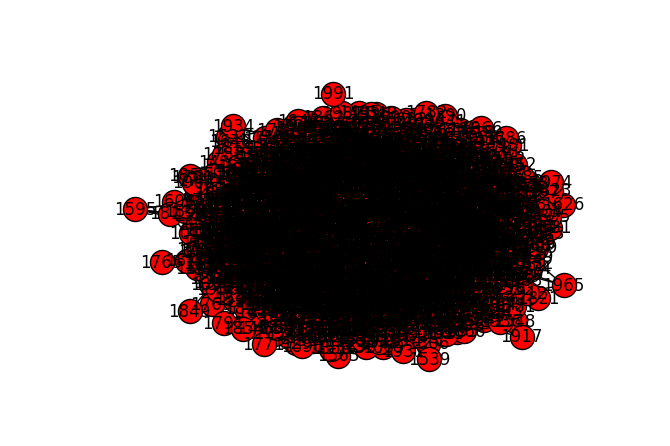

In [3]:
G = nx.barabasi_albert_graph(n = 2000, m = 4, seed=123)
nx.draw(G, with_labels=True)
plt.show()

The degree distribution looks like power distribution (as it was supposed to):

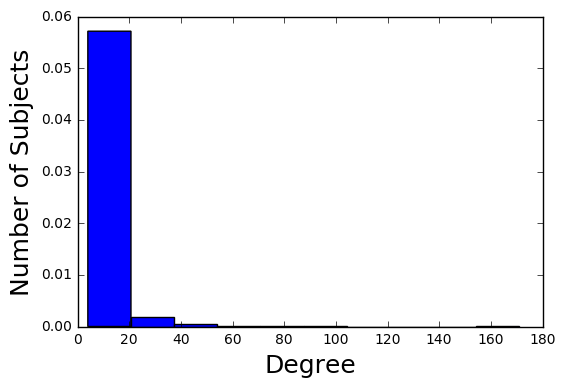

In [4]:
plt.hist(list(nx.degree(G).values()),normed = True)
plt.xlabel('Degree',fontsize=18)
plt.ylabel('Number of Subjects',fontsize=18)
plt.show()


Here we will have the class **SIRSimulator()** with all methods that we will need in order to perform different SIR simulations.

The paremeters are:

**graph** - graph to analize

**im** - list of immunized nodes (if any)

**beta** - probability of getting infected

**mu** - probability of being cured

**r** - immunization rate (if any)

There are also two methods:

**run()** is used for a regular SIR simulation without immunization or with random immunization (if **r** is given) or with a given list of immunized nodes.

**run_smart()** is used in order to simulate SIR with immuninized hub nodes


In [5]:
class SIRSimulator:
    def __init__(self, graph, im = None, beta=0.25, mu=0.05, r = 0):
        self.g = graph   
        self.BETA = beta
        self.MU = mu
        self.r = r
        if im is None:
            self.IM = []
        else:
            self.IM = im
    
    def run(self, seed=[], num_steps=1):
        G1 = self.g.copy()
        N = len(G1.nodes())
        if len(self.IM) == 0:
            num = int(round(N*self.r))
            IM = np.random.choice(N-1,size = num,replace = False)
        else: 
            IM = self.IM
        for node in IM:
            G1.remove_node(int(node))
        # if no seed is specified, choose 1 node at random
        if not len(seed):
            seed = [np.random.choice(G1.nodes()) ]
            
        # initialize sets of S/I/R nodes
        I_set = set(seed)
        S_set = set(G1.nodes()).difference(I_set)
        R_set = set()
        t = 0
        IM_set = set(IM)
        
        StoI_set = set(seed) # nodes that underwent S->I transition
        ItoR_set = set() # nodes that underwent I->R transition
 
        while True:
            # generator logic: yield current status every num_steps iterations
            if t % num_steps == 0:
                yield { 't': t, 'S': S_set, 'I': I_set, 'R': R_set,
                       'S->I': StoI_set, 'I->R': ItoR_set,'IM': IM_set }
            
            # stop when there are no infectious nodes left
            if not len(I_set):
                break

            StoI_set = set()
            ItoR_set = set()
            
            # loop over neighbors of infectious nodes
            for i in set(I_set):
                # TRANSMISSION
                for j in S_set.intersection(G1.neighbors(i)):
                    if np.random.uniform() < self.BETA:
                        S_set.remove(j)
                        I_set.add(j)
                        StoI_set.add(j)
                        
                # RECOVERY
                if np.random.uniform() < self.MU:
                    I_set.remove(i)
                    R_set.add(i)
                    ItoR_set.add(i)
      
            t += 1
            IM_set = IM
    
    def run_smart(self, seed=[], num_steps=1):
        G1 = self.g.copy()
        N = len(G1.nodes())
        num = int(round(N*self.r))        
        max_n = np.zeros(num)
        to_drop = np.zeros(num)
        for j in range(num):
            for i in G1.nodes():
                if len(G1.neighbors(i))>=max_n[j]:
                    max_n[j] = len(G1.neighbors(i))
                    to_drop[j] = i
            G1.remove_node(int(to_drop[j]))
        # if no seed is specified, choose 1 node at random
        if not len(seed):
            seed = [np.random.choice(G1.nodes()) ]
            
        # initialize sets of S/I/R nodes
        I_set = set(seed)
        S_set = set(G1.nodes()).difference(I_set)
        R_set = set()
        t = 0
        IM_set = set(to_drop)
        
        StoI_set = set(seed) # nodes that underwent S->I transition
        ItoR_set = set() # nodes that underwent I->R transition
 
        while True:
            # generator logic: yield current status every num_steps iterations
            if t % num_steps == 0:
                yield { 't': t, 'S': S_set, 'I': I_set, 'R': R_set,
                       'S->I': StoI_set, 'I->R': ItoR_set,'IM': IM_set }
            
            # stop when there are no infectious nodes left
            if not len(I_set):
                break

            StoI_set = set()
            ItoR_set = set()
            
            # loop over neighbors of infectious nodes
            for i in set(I_set):
                # TRANSMISSION
                for j in S_set.intersection(G1.neighbors(i)):
                    if np.random.uniform() < self.BETA:
                        S_set.remove(j)
                        I_set.add(j)
                        StoI_set.add(j)
                        
                # RECOVERY
                if np.random.uniform() < self.MU:
                    I_set.remove(i)
                    R_set.add(i)
                    ItoR_set.add(i)
      
            t += 1
            IM_set = IM

  

## 1.2 - A simulation of an SIR epidemic process on the graph that allows the epidemic to take off with high probability

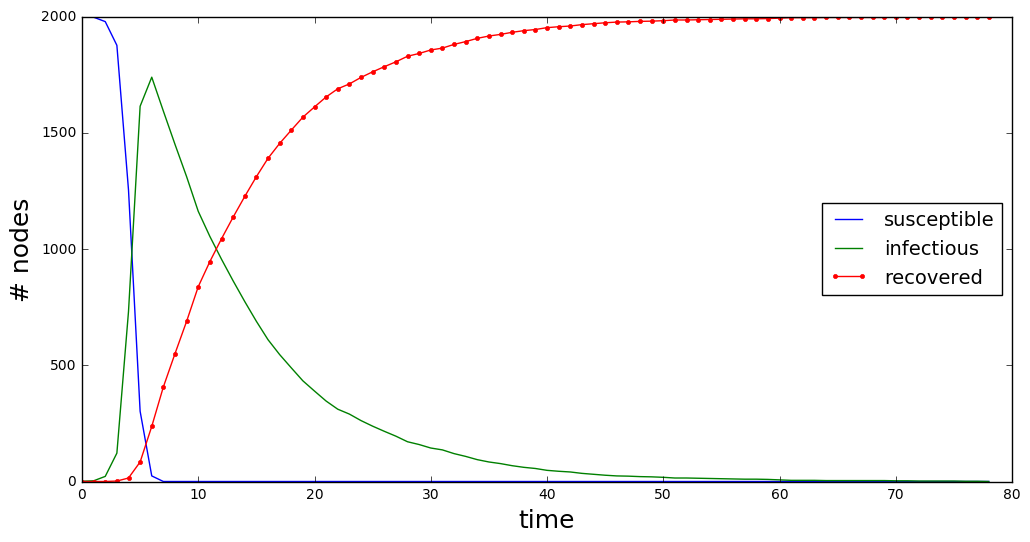

In [6]:
SIR = SIRSimulator(G, beta=0.5, mu=0.1)
S = []
R = []
I = []
for status in SIR.run():
    S.append(len(status['S']))
    R.append(len(status['R']))
    I.append(len(status['I']))
t = np.arange(len(S))
plt.figure(figsize=(12,6))
plt.plot(t,S, t,I, t, R, '.-')
plt.xlabel('time', fontsize=18)
plt.ylabel('# nodes', fontsize=18)
plt.legend(['susceptible', 'infectious', 'recovered'], fontsize=14, loc=7)
plt.show()

### 1.3.1   Epidemic curves for multiple stochastic realizations of the epidemic:

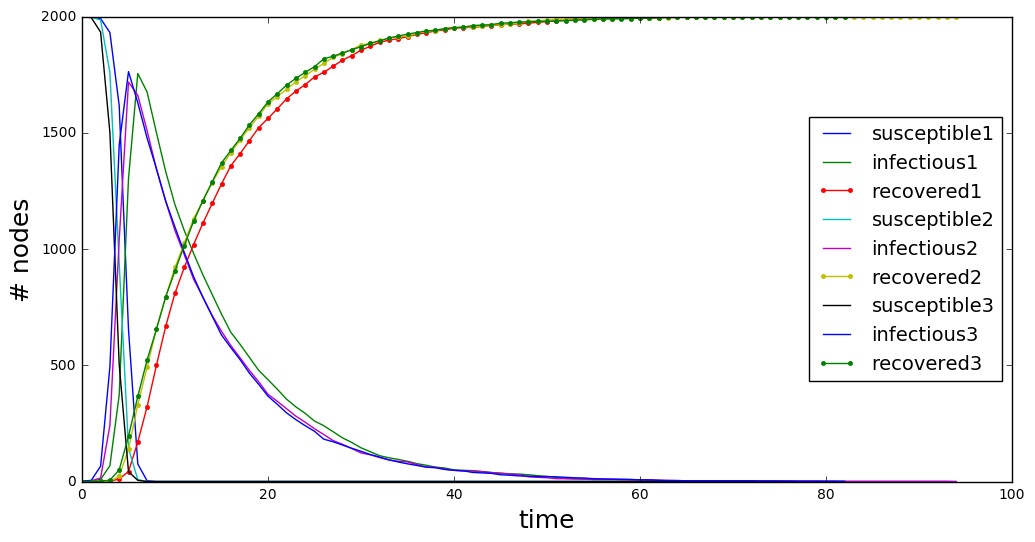

In [7]:
plt.figure(figsize=(12,6))
for _ in range(3):
    S = []
    R = []
    I = []
    for status in SIR.run():
        S.append(len(status['S']))
        R.append(len(status['R']))
        I.append(len(status['I']))
    t = np.arange(len(S))
    plt.plot(t,S, t,I, t, R, '.-')
plt.xlabel('time', fontsize=18)
plt.ylabel('# nodes', fontsize=18)
plt.legend(['susceptible1', 'infectious1', 'recovered1','susceptible2', 'infectious2', 'recovered2',
           'susceptible3', 'infectious3', 'recovered3'], fontsize=14, loc=7)
plt.show()

### 1.3.2 The probability distribution of the overall attack rate and the probability distribution of peak times for the epidemic

At this point, I prefere to fix $\mu$ in the same level and vary $\beta$ in order to study how probability of getting infected is related to attack rate and peak-times for an epidemic

In [12]:
betas = np.arange(0.01,0.2,0.005)
mu = 0.1
num_sim = 20
N = len(G.nodes())
peak = np.zeros((num_sim,len(betas)))
a_r = np.zeros((num_sim,len(betas)))
p = 0
for b in betas:
    for i in range(num_sim):
        SIR = SIRSimulator(G, beta=b, mu=0.1)
        R = []
        I = []
        for status in SIR.run():
            #S.append(len(status['S']))
            R.append(len(status['R']))
            I.append(len(status['I']))
        t = np.arange(len(I))
        peak[i,p] =t[np.argmax(I)]
        a_r[i,p] =(R[-1]/N)
    p = p+1


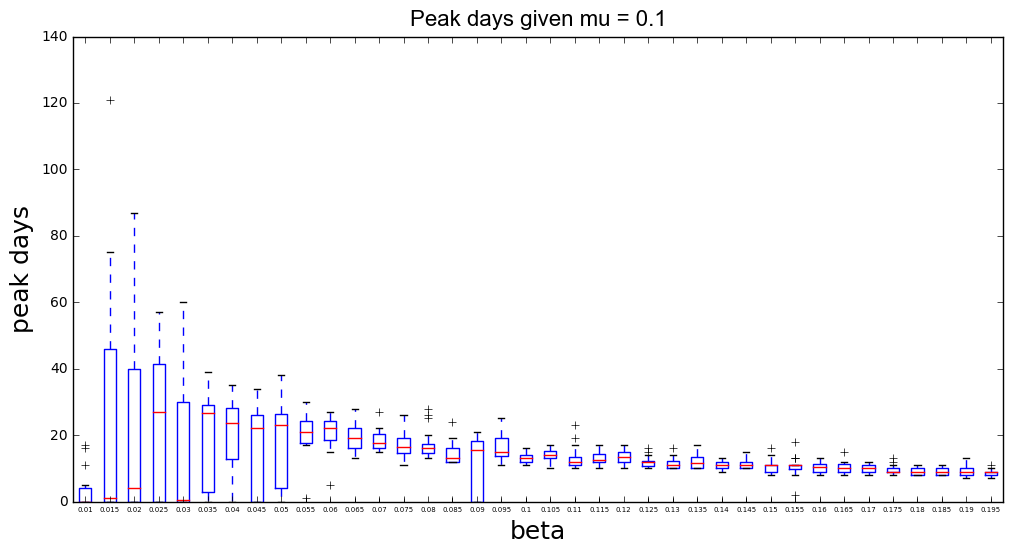

In [13]:
plt.figure(figsize=(12,6))
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
plt.title("Peak days given mu = 0.1",**title_font)
plt.tick_params(axis='x', which='major', labelsize=5)
plt.tick_params(axis='x', which='minor', labelsize=5)
plt.xlabel('beta', fontsize=18)
plt.ylabel('peak days', fontsize=18)
plt.boxplot(peak,labels = betas)
plt.show()

The plot makes totall sence: with a very small probability of an infection (0.01) the infection may not even start so the pick day is 0.

As $\beta$ is increasing (0.015-0.03) the infection may actually take a place, but it takes quite long to reach the pick day. Also in this case we we see quite a high variation since it's still quite possible that infection won't even start&

Starting from $\beta = 0.03$  we are able to see that with increasing probability of an infection it takes less and less to reach a pick with quite a big confidence 

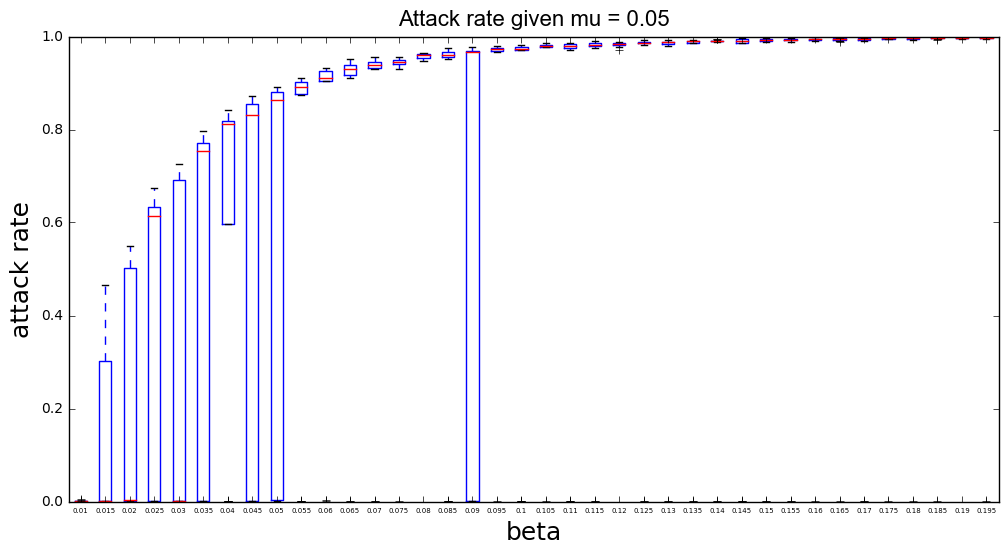

In [14]:
plt.figure(figsize=(12,6))
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
plt.title("Attack rate given mu = 0.05",**title_font)
plt.tick_params(axis='x', which='major', labelsize=5)
plt.tick_params(axis='x', which='minor', labelsize=5)
plt.xlabel('beta', fontsize=18)
plt.ylabel('attack rate', fontsize=18)
plt.boxplot(a_r,labels = betas)
plt.show()

Attack rate shows a proportion of population that was infected.

We can conclude that if $\beta>0.055$ and $\mu = 0.1$ then all the population will get infected almost surely

## 	2.1 - The simulation  that supports a given initial fraction r of randomly chosen "immunized" nodes 
### 2.1.1 Can you provide an upper bound for the overall attack rate without having to simulate the epidemic?
Yes, it's $\frac{N-r*N}{N} =1-r$


### 2.1.2 The simulation with r = 0.2


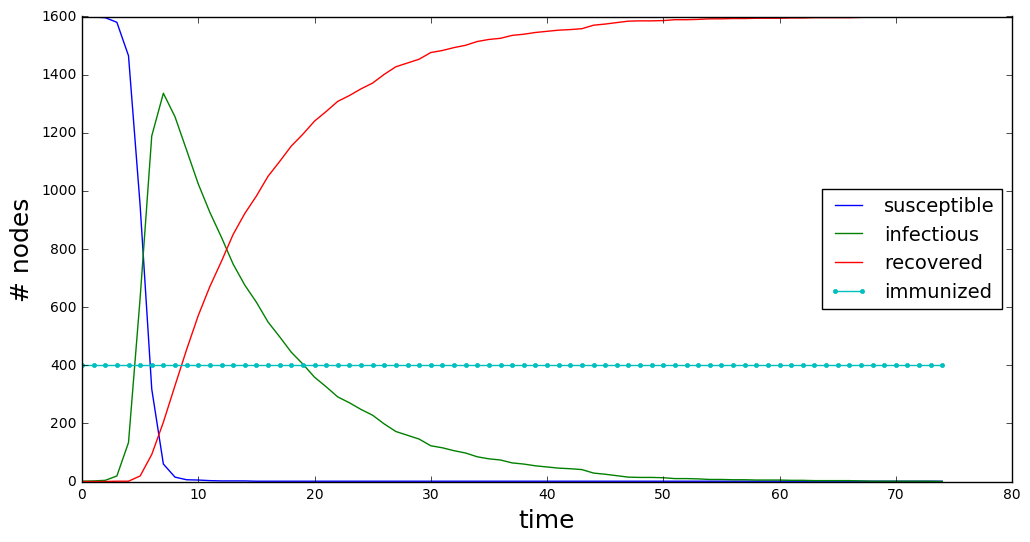

In [15]:
SIR = SIRSimulator(G, beta=0.5, mu=0.1, r = 0.2)
S = []
R = []
I = []
IM = []
for status in SIR.run():
    S.append(len(status['S']))
    R.append(len(status['R']))
    I.append(len(status['I']))
    IM.append(len(status['IM']))
t = np.arange(len(S))
plt.figure(figsize=(12,6))
plt.plot(t,S, t,I, t, R,t,IM, '.-')
plt.xlabel('time', fontsize=18)
plt.ylabel('# nodes', fontsize=18)
plt.legend(['susceptible', 'infectious', 'recovered',"immunized"], fontsize=14, loc=7)
plt.show()

## 2.2 Multiple realizations of the epidemic for each value of r:
At this point let's fix $\mu = 0.1$ and $\beta = 0.5$ - the set-up we had in **1.2** which allowed an epidemic to take off quite fast

In [16]:
rs = np.arange(0.01,1,0.04)
num_sim = 20
a_r = np.zeros((num_sim,len(rs)))
p = 0
for r in rs:
    SIR = SIRSimulator(G, beta= 0.5, mu=0.1, r = r)
    for i in range(num_sim):
        #S = []
        R = []
        #I = []
        for status in SIR.run():
            #S.append(len(status['S']))
            R.append(len(status['R']))
            #I.append(len(status['I']))
        t = np.arange(len(R))
        #peak[i,p] =t[np.argmax(I)]
        a_r[i,p] =(R[-1]/N)
    p = p+1
rand_sim = np.mean(a_r, axis=0)


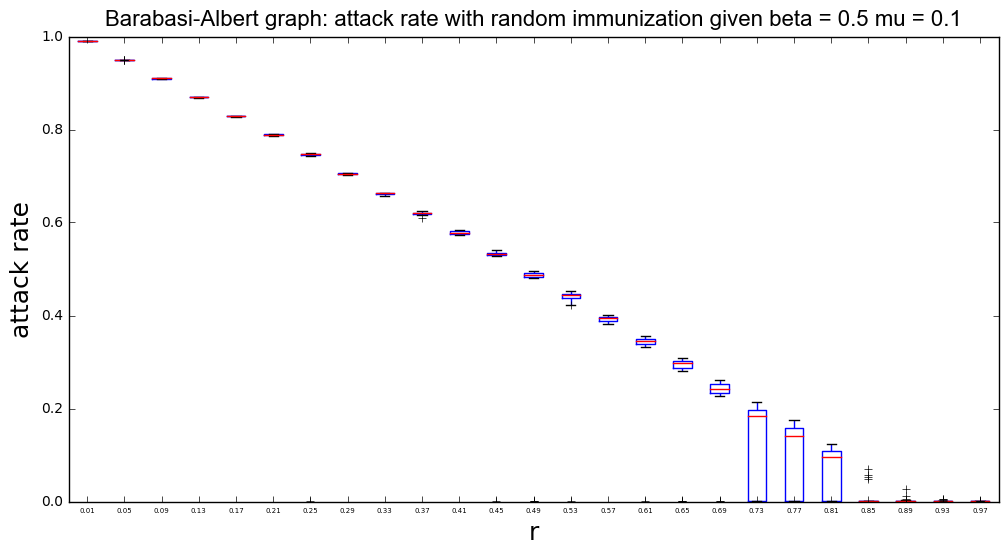

In [18]:
plt.figure(figsize=(12,6))
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
plt.title("Barabasi-Albert graph: attack rate with random immunization given beta = 0.5 mu = 0.1",**title_font)
plt.tick_params(axis='x', which='major', labelsize=5)
plt.tick_params(axis='x', which='minor', labelsize=5)
plt.xlabel('r', fontsize=18)
plt.ylabel('attack rate', fontsize=18)
plt.boxplot(a_r,labels = rs)
plt.show()


Looks quite credible that with if proportion of immunized population increase we will have more people who didn't even got sick.

High variation at some points(from 0.73 to 0.81) is natural since with big enough number of immunized people we depend a lot on the random choice and hence the result can vary a little

## 2.3 - A random with the same size and density as the original social network and multiple realizations of the epidemic for each value of r:
### 2.3.1 A random Erdős–Rényi graph:

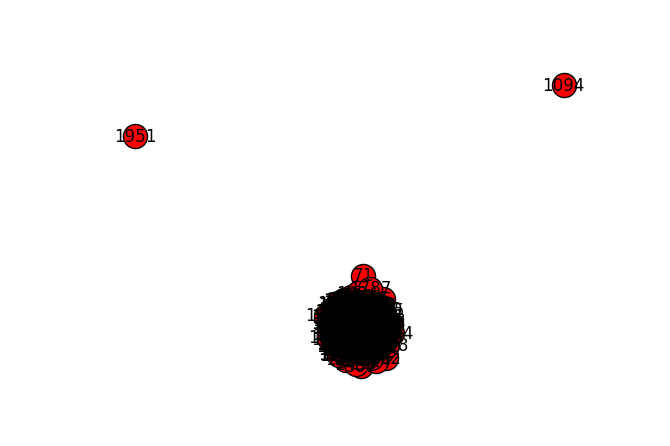

Original densety:7.984 Erdős–Rényi graph density:7.967


In [23]:
N = 2000
G_dens = sum(list(nx.degree(G).values()))/N
G_e = nx.erdos_renyi_graph(n= N, p = 0.004)
G_e_dens = sum(list(nx.degree(G_e).values()))/N
nx.draw(G_e, with_labels=True)
plt.show()
print("Original densety:" + str(G_dens)+ " Erdős–Rényi graph density:"+ str(G_e_dens))


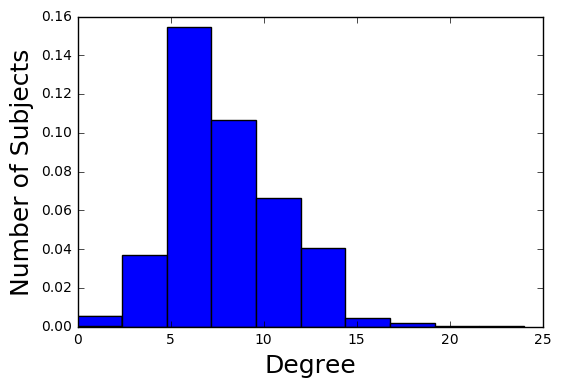

In [24]:
plt.hist(list(nx.degree(G_e).values()),normed = True)
plt.xlabel('Degree',fontsize=18)
plt.ylabel('Number of Subjects',fontsize=18)
plt.show()

### 2.3.2 Multiple realizations of the epidemic for each value of r for a Erdős–Rényi graph:

In [25]:
a_r = np.zeros((num_sim,len(rs)))
p = 0
for r in rs:
    for i in range(num_sim):
        SIR = SIRSimulator(G_e, beta= 0.5, mu=0.1, r = r)
        R = []
        for status in SIR.run():
            R.append(len(status['R']))
        t = np.arange(len(R))
        a_r[i,p] =(R[-1]/N)
    p = p+1
erdos_rand_sim = np.mean(a_r, axis=0)



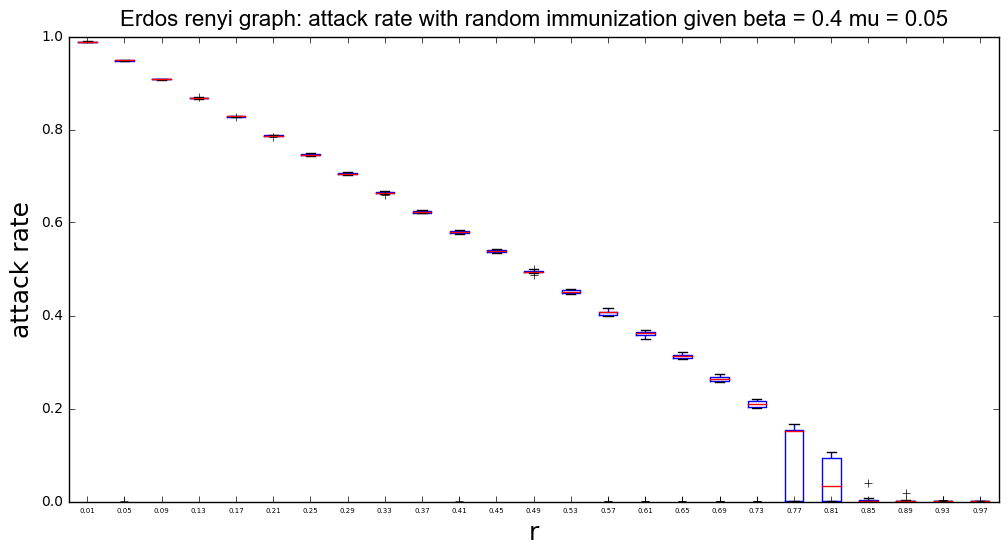

In [26]:
plt.figure(figsize=(12,6))
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
plt.title("Erdos renyi graph: attack rate with random immunization given beta = 0.4 mu = 0.05",**title_font)
plt.tick_params(axis='x', which='major', labelsize=5)
plt.tick_params(axis='x', which='minor', labelsize=5)
plt.xlabel('r', fontsize=18)
plt.ylabel('attack rate', fontsize=18)
plt.boxplot(a_r,labels = rs)
plt.show()

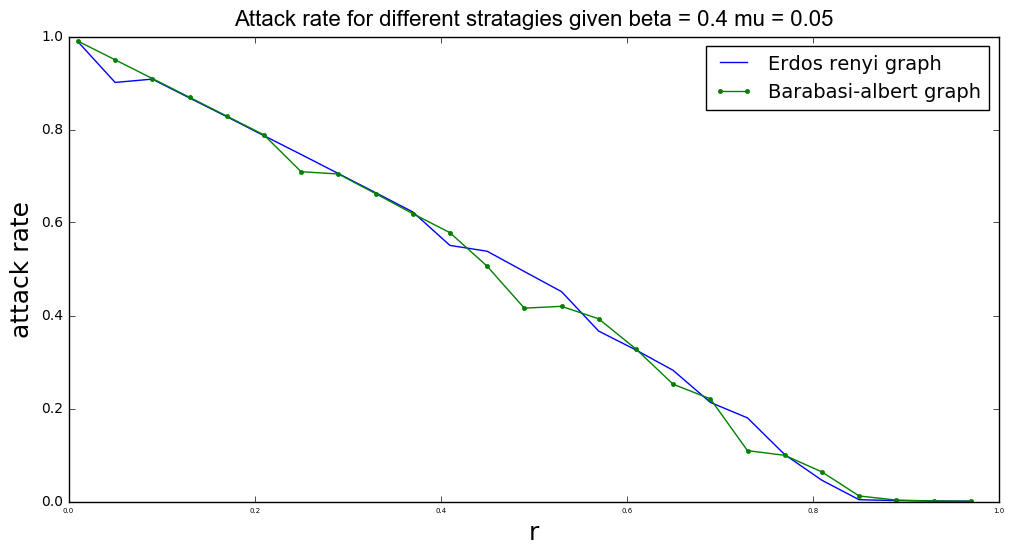

In [30]:
plt.figure(figsize=(12,6))
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
plt.title("Attack rate for different stratagies given beta = 0.4 mu = 0.05",**title_font)
plt.tick_params(axis='x', which='major', labelsize=5)
plt.tick_params(axis='x', which='minor', labelsize=5)
plt.xlabel('r', fontsize=18)
plt.ylabel('attack rate', fontsize=18)
plt.plot(rs,erdos_rand_sim,rs, rand_sim,'.-')
plt.legend(['Erdos renyi graph', 'Barabasi-albert graph'], fontsize=14, loc=1)
plt.show()

We can see that that the uncertancy is  smaller then for the initial graph. It related to the fact that Erdos renyi graph has normal distribution for degrees, while Barabasi-Albert graph has power degree distribution which means that if one of the hyper-connected nodes is getting immunised the result will differ a lot from the situation when a node with low degree is getting "immune" (which is much more probable with power distribution).

With normal distribution random choice will most probably "immunise" high-degree nodes, since the mass of the distribution is concentrated there.

# PART 3: TARGETED VACCINATION STRATEGIES
## 3.1 "Targeted" immunization and comparing the results with Part 2.2:
### 3.1.1 "Targeted" immunization 
As it was said before, for the power distribution we have very different results depending on the degree of the immunized node. Thus it makes sense to choose M the most important nodes and "immunize" them. The question is which node may be considered as the most important: the one with the highest degree or the one with the highest betweenness centrality? I assume that with barabasi-albert graph we don't have strong cluster structure inside and so these two measures are supposed to be the same, but we can easily check this assumption:

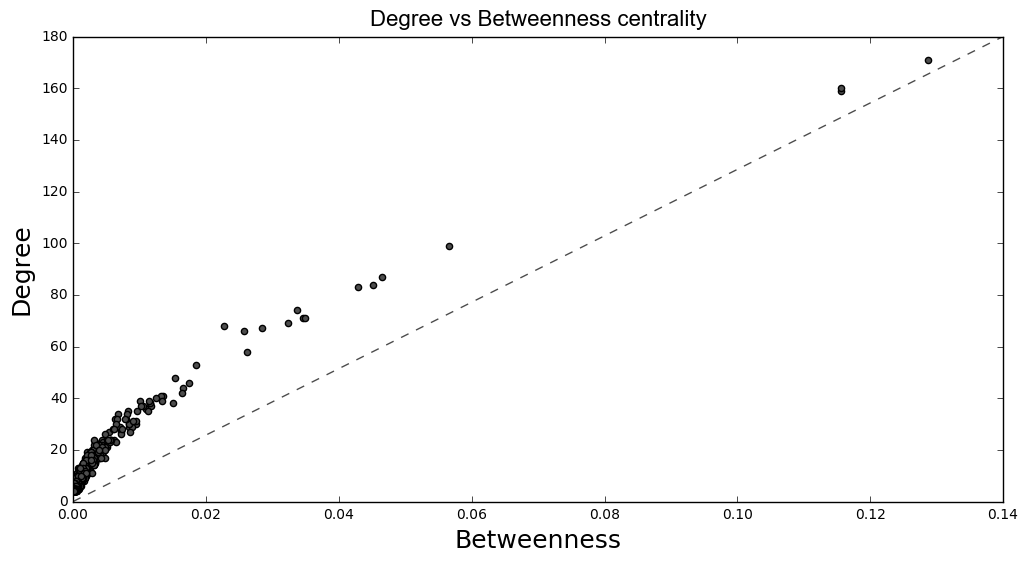

In [92]:
bc = nx.betweenness_centrality(G)
bc = list(bc.values())
deg = list(nx.degree(G).values())
f, ax = plt.subplots(figsize=(12, 6))
ax.scatter(bc, deg, c=".3")
ax.set(xlim=(0, 0.14), ylim=(0, 180))
diag_line, = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
plt.title("Degree vs Betweenness centrality",**title_font)
plt.xlabel('Betweenness', fontsize=18)
plt.ylabel('Degree', fontsize=18)
plt.show()

As we can see, the relation is close to linear, but sometimes we can choose different nodes by degree and by betweenness centrality. But the complexity of computing betweenness centrality is $N^2$ while the complexity of computing degree is linear. So we define "the most important node" as the one with the highest degree.

The implementation was done in the method **run_smart()**
### 3.1.2  Multiple realizations of the epidemic for each value of r with "targeted" immunization:

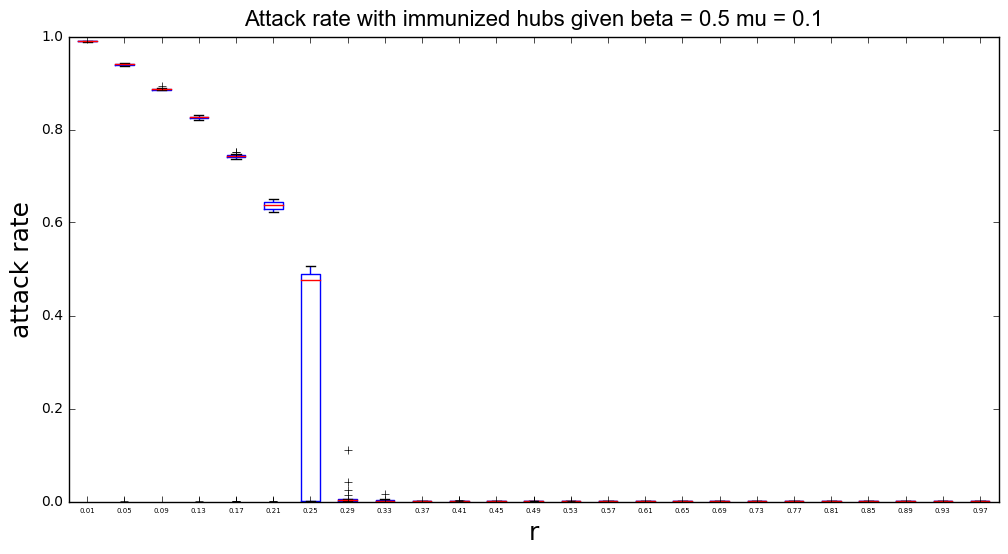

In [31]:
a_r = np.zeros((num_sim,len(rs)))
p = 0
for r in rs:
    for i in range(num_sim):
        SIR = SIRSimulator(G, beta= 0.5, mu=0.1, r = r)
        R = []
        for status in SIR.run_smart():
            R.append(len(status['R']))
        a_r[i,p] =(R[-1]/N)
    p = p+1
im_hubs_sim = np.mean(a_r, axis=0)
    
plt.figure(figsize=(12,6))
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
plt.title("Attack rate with immunized hubs given beta = 0.5 mu = 0.1",**title_font)
plt.tick_params(axis='x', which='major', labelsize=5)
plt.tick_params(axis='x', which='minor', labelsize=5)
plt.xlabel('r', fontsize=18)
plt.ylabel('attack rate', fontsize=18)
plt.boxplot(a_r,labels = rs)
plt.show()


Now we see that the effect of immunization is much more significant: we can immunize around 30 % of the population and no one will get sick

## 3.2 - Optimal stratagy without information about graph structure
This isn't a very trivial task to solve so let's first try an idea on a toy example: a barabasi-albert-graph with only 10 nodes.

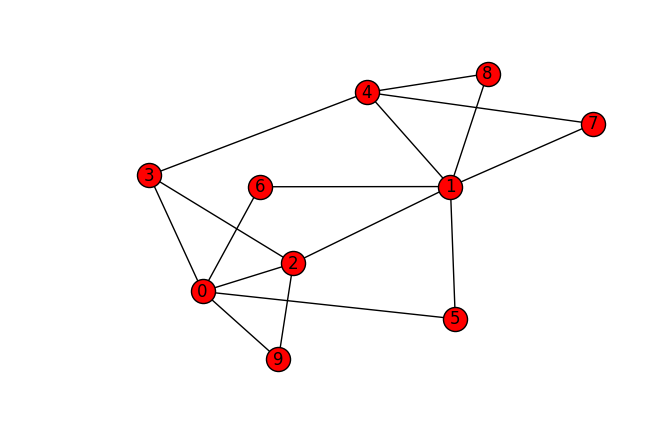

In [35]:
G1 = nx.barabasi_albert_graph(n = 10, m = 2, seed=123)
nx.draw(G1, with_labels=True)
plt.show()


Now we can see, that ideally we would like to immunize node with the highest degrees (or betweenness centrality). If we have M = 2 vaccines those would be node 0,1, if we have M = 3 vaccines then: 0,1,2 or 0,1,4 and so on.

The idea was the following: when a hub node is getting infected it gives the biggest boost to the set of infected nodes. So we can try to check which nodes got infected just before an epedimic got a boost

In [36]:
SIR = SIRSimulator(G1, beta= 0.5, mu=0.1, r = 0)
suspects= {}
r = 0.3 
M = int(round(r*len(G1)))
for _ in range(1000):
    #S = []
    #R = []
    I = []
    I_inc = []
    all_I = []
    all_R = []
    t = 0
    for status in SIR.run():
        S.append(len(status['S']))
        R.append(len(status['R']))
        I.append(len(status['I']))
        all_I.append(set(status['I']))
        all_R.append(set(status['R']))
        t =t+1
    I_inc = [I[i]-I[i-1] for i in range(1,len(I))] 
    s = all_I[np.argmax(I_inc)] #nodes that got infected just before an epidemic got a boost
    #now lets out them into a dictionary so we will be able to track this information over all simulations
    for node in s:
        if suspects.get(node) == None:
            suspects[node] = 0
        else:
            suspects[node] = suspects[node] + 1
sorted_x = sorted(suspects.items(), key=operator.itemgetter(1),reverse=True)# sorting the result into decentic order
top = [k for k,v in sorted_x[0:M]]#picking M the most probable
top

[1, 0, 4]

Seems to make sence, now let's see if we can make it work on the whole graph:


In [37]:
def hubs(G,r,num_sim):
    SIR = SIRSimulator(G, beta= 0.3, mu=0.05, r = 0)
    suspects= {}
    M = int(round(r*len(G)))
    for _ in range(num_sim):
        #S = []
        #R = []
        I = []
        I_inc = []
        all_I = []
        all_R = []
        t = 0
        for status in SIR.run():
            S.append(len(status['S']))
            R.append(len(status['R']))
            I.append(len(status['I']))
            all_I.append(set(status['I']))
            all_R.append(set(status['R']))
            t =t+1
        I_inc = [I[i]-I[i-1] for i in range(1,len(I))] 
        s = all_I[np.argmax(I_inc)] #nodes that got infected just before an epidemic got a boost
        #now lets out them into a dictionary so we will be able to track this information over all simulations
        for node in s:
            if suspects.get(node) == None:
                suspects[node] = 0
            else:
                suspects[node] = suspects[node] + 1
    sorted_x = sorted(suspects.items(), key=operator.itemgetter(1),reverse=True)# sorting the result into decentic order
    top = [k for k,v in sorted_x[0:M]]#picking M the most probable
    return(top)

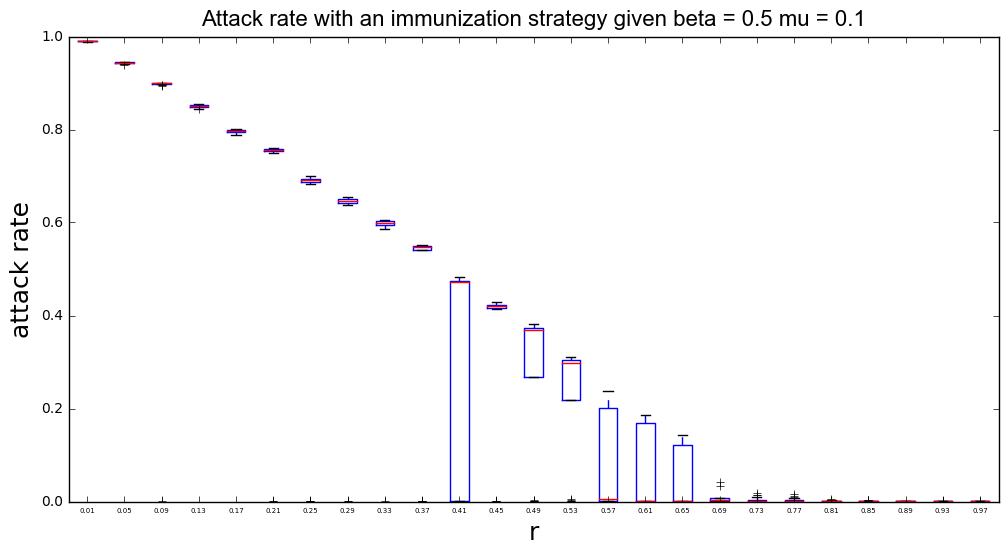

In [38]:
rs = np.arange(0.01,1,0.04)
num_sim = 20
a_r = np.zeros((num_sim,len(rs)))
p = 0
for r in rs:
    im = hubs(G,r,30)
    for i in range(num_sim):
        SIR = SIRSimulator(G, beta= 0.5, mu=0.1, im = im, r = 0)
        R = []
        for status in SIR.run():
            R.append(len(status['R']))
        t = np.arange(len(R))
        a_r[i,p] =(R[-1]/N)
    p = p+1
    #print(p)
im_str_sim = np.mean(a_r, axis=0)

plt.figure(figsize=(12,6))
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
plt.title("Attack rate with an immunization strategy given beta = 0.5 mu = 0.1",**title_font)
plt.tick_params(axis='x', which='major', labelsize=5)
plt.tick_params(axis='x', which='minor', labelsize=5)
plt.xlabel('r', fontsize=18)
plt.ylabel('attack rate', fontsize=18)
plt.boxplot(a_r,labels = rs)
plt.show()


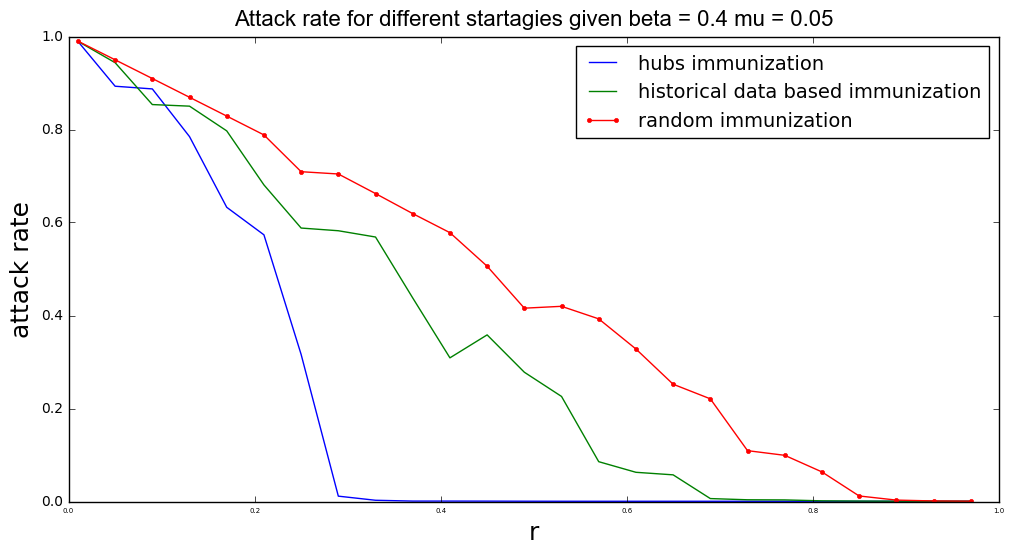

In [41]:
plt.figure(figsize=(12,6))
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
plt.title("Attack rate for different startagies given beta = 0.4 mu = 0.05",**title_font)
plt.tick_params(axis='x', which='major', labelsize=5)
plt.tick_params(axis='x', which='minor', labelsize=5)
plt.xlabel('r', fontsize=18)
plt.ylabel('attack rate', fontsize=18)
plt.plot(rs,im_hubs_sim,rs,im_str_sim,rs, rand_sim,'.-')
plt.legend(['hubs immunization', "historical data based immunization","random immunization"], fontsize=14, loc=1)
plt.show()

The result is much better then with random immunization since here we can see that almost no one will get sick if we vaccinize more then 57% of the population (85% for a random vaccination and 30% for a targeted vacccination of the hubs)

## 3.3 - A targeted immunization strategy that makes use of the partial information about the graph

A reasonable stratagy here is the one when we are building a sub-graph with given information and then if the node has degree biger then a certain threshold then we add it to the list of immunized nodes or otherwise we make a random choice.

In [44]:
N = len(G2.nodes())
th = int(np.mean(list(nx.degree(G).values())))
K = np.random.choice(N-1,size = int(0.1*N),replace = False)
def part_hubs(K,r,G2,th):
    inf = {}
    N = len(G2.nodes())
    for node in K:
        inf[node] = G2.neighbors(node)
    dig = {}
    for key in inf:
        if dig.get(key) == None:
            dig[key] = len(inf[key])
        else:
            dig[key] = dig[key] + len(inf[key])
        for node in inf[key]:
            if dig.get(node) == None:
                dig[node] = 1
            else:
                dig[node] = dig[node]+1
    im =[]
    M = int(r*N)
    for key in dig:
        if dig[key]>=th:
            im.append(key)
    if len(im)<M:
        while len(set(im)) != M:
            im.append(int(np.random.choice(N-1,size = 1,replace = False)))
    return(list(set(im)))

Thereshold equal to 2 seems reasonably better then others so lets go with it:

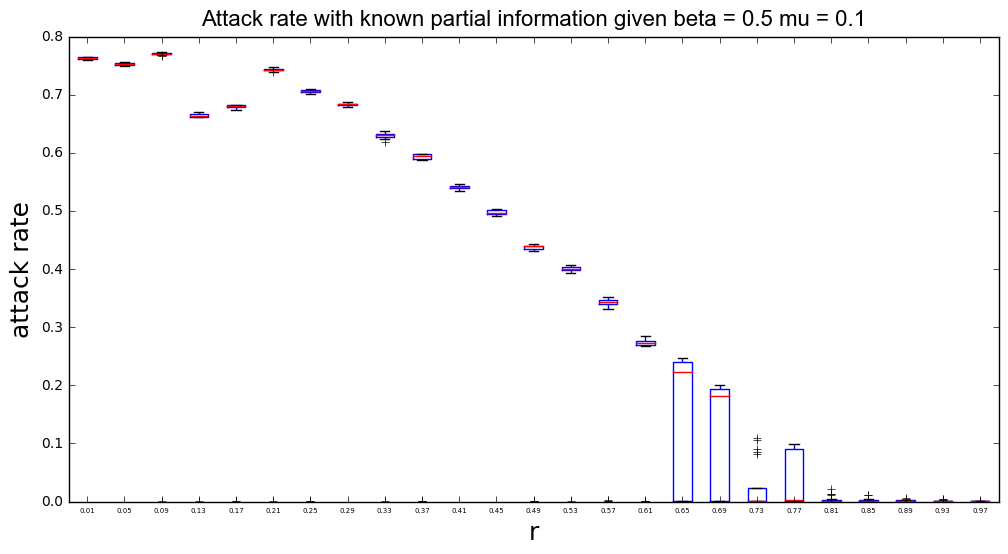

In [47]:
N = len(G.nodes())
rs = np.arange(0.01,1,0.04)
num_sim = 20
a_r = np.zeros((num_sim,len(rs)))
p = 0
for r in rs:
    K = np.random.choice(N-1,size = int(0.1*N),replace = False)
    im = part_hubs(K,r,G,2)
    for i in range(num_sim):
        SIR = SIRSimulator(G, beta= 0.5, mu=0.1, im = im, r = 0)
        #S = []
        R = []
        #I = []
        for status in SIR.run():
            #S.append(len(status['S']))
            R.append(len(status['R']))
            #I.append(len(status['I']))
        a_r[i,p] =(R[-1]/N)
    p = p+1
    #print(p)
im_par_sim = np.mean(a_r, axis=0)
plt.figure(figsize=(12,6))
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
plt.title("Attack rate with known partial information given beta = 0.5 mu = 0.1",**title_font)
plt.tick_params(axis='x', which='major', labelsize=5)
plt.tick_params(axis='x', which='minor', labelsize=5)
plt.xlabel('r', fontsize=18)
plt.ylabel('attack rate', fontsize=18)
plt.boxplot(a_r,labels = rs)
plt.show()


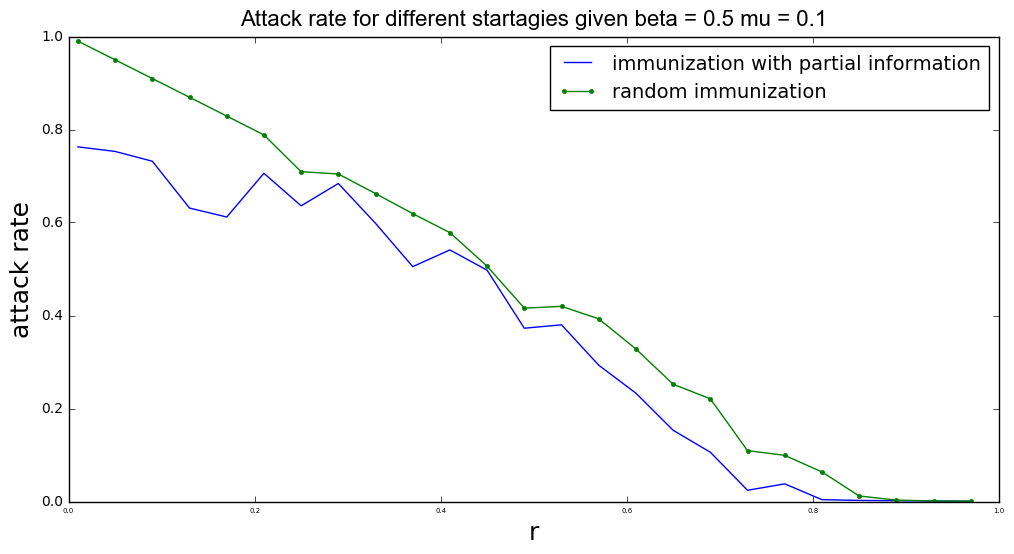

In [49]:
plt.figure(figsize=(12,6))
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
plt.title("Attack rate for different startagies given beta = 0.5 mu = 0.1",**title_font)
plt.tick_params(axis='x', which='major', labelsize=5)
plt.tick_params(axis='x', which='minor', labelsize=5)
plt.xlabel('r', fontsize=18)
plt.ylabel('attack rate', fontsize=18)
t = np.arange(len(im_par_sim))
plt.plot(rs,im_par_sim,rs,rand_sim,'.-')
plt.legend(['immunization with partial information', "random immunization"], fontsize=14, loc=1)
plt.show()

The sesult seems to make sence: we can take a nice advantage knowing subgraph with 10% of all nodes and their neighbors.

Although, I believe that I used that 10% of the information in quite a proficent way since we significally overperform random choice algorithm up to r = 0.22